In [1]:
#Import dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
%matplotlib inline
import IPython
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import sys
import copy
import skimage as ski
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [21]:
sys.path.append("../Manjari/STalign/STalign")
import STalign_nocontrast as STalign

In [22]:
STalign.hi5()

hi1


In [23]:
imagefile = 'aba_nissl.nrrd'
labelfile = 'aba_annotation.nrrd'

In [24]:
# Open image
filename = 'hyopil_1.jpg'
W = ski.io.imread(filename)
print(W.shape)

im = plt.imshow(W)

(4386, 3916, 3)


C:\Users\Manjari\AppData\Local\Temp\ipykernel_19324\3253596651.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  im = plt.imshow(W)


Pre-Processing

In [25]:
# Basic preprocessing: gray-scaling, inverting, and normalizing
W_ = ski.color.rgb2gray(W) #then to gray scale
W_ = np.max(W_) - W_ # invert colors
W_ = (W_ - np.min(W_))/(np.max(W_) - np.min(W_)) #then normalize

im = plt.imshow(W_)

C:\Users\Manjari\AppData\Local\Temp\ipykernel_19324\401591241.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  im = plt.imshow(W_)


In [26]:
# Bright Spot Removal
W__ = np.copy(W_)

# manually set the bright squares to 0
W__[3400:,3000:] = 0
W__[:500,3000:] = 0
W__[450:1500,3700:] = 0
W__[2000:2500, :50] = 0
W__[2400:,:30] = 0
W__[4300:] = 0
print(W__.shape)

im = plt.imshow(W__)
#print(W__[5000:])

(4386, 3916)


C:\Users\Manjari\AppData\Local\Temp\ipykernel_19324\864282437.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  im = plt.imshow(W__)


<IPython.core.display.Javascript object>


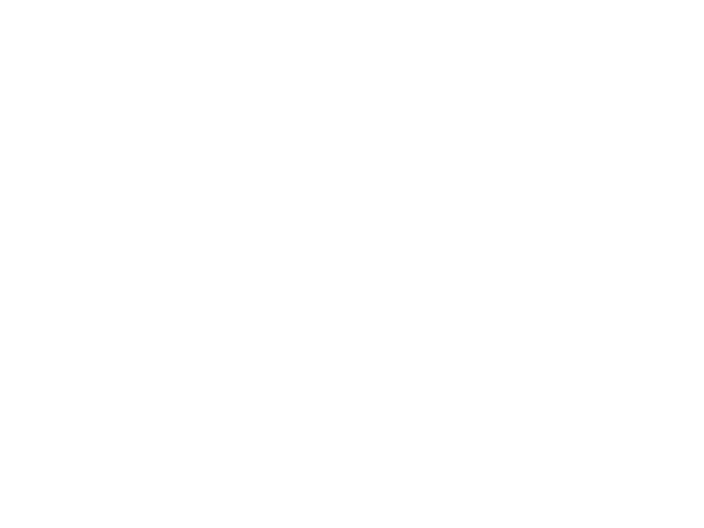

<IPython.core.display.Javascript object>


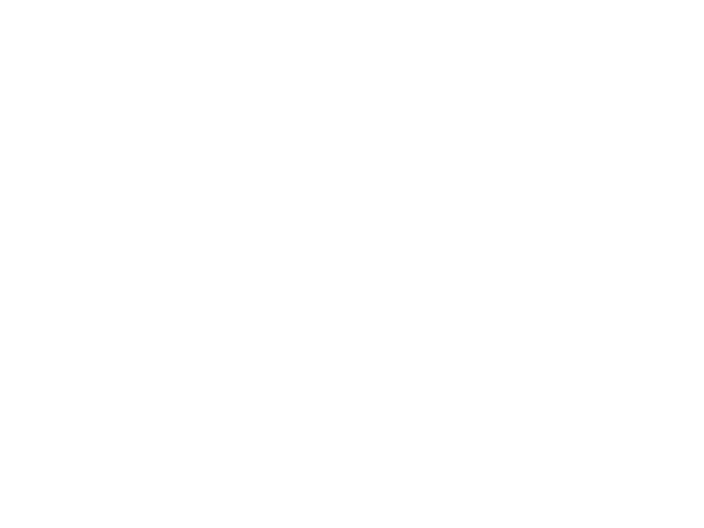

<IPython.core.display.Javascript object>


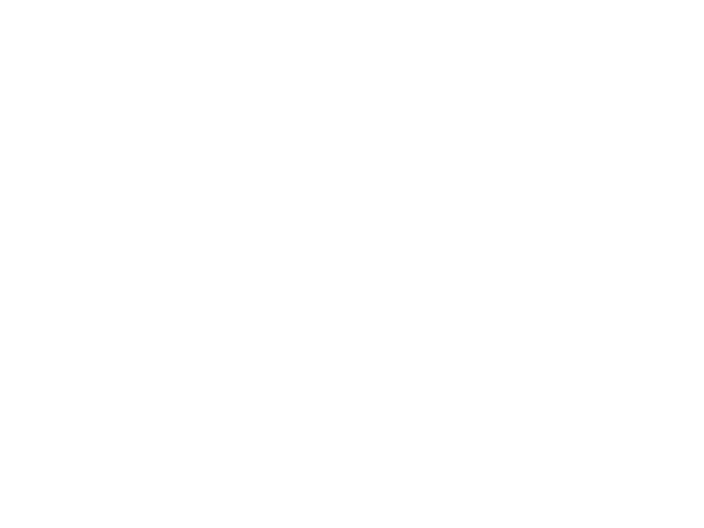

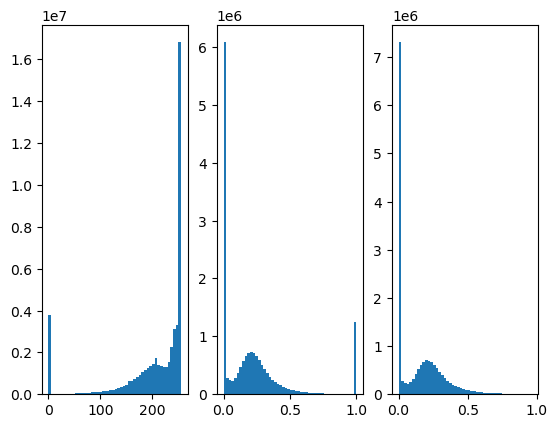

In [27]:
# Intensity Histogram
fig,ax = plt.subplots(1,3)
ax[0].hist(W.ravel(),bins=50);
ax[1].hist(W_.ravel(),bins=50);
ax[2].hist(W__.ravel(),bins=50);

Padding (either rigid or adaptive)

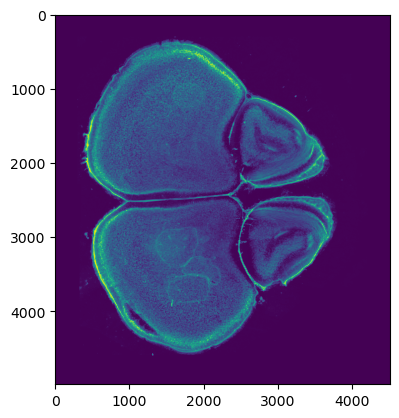

In [28]:
# rigid padding
# add padding of 300 rows/cols
pad = 300
W = np.pad(W__,((pad,pad),(pad,pad)),'minimum')

im = plt.imshow(W)

Goal aspect ratio: 0.7017543859649122
Recommended padding: ((300, 300), (2164, 2164))
(4386, 3916) 1.120020429009193


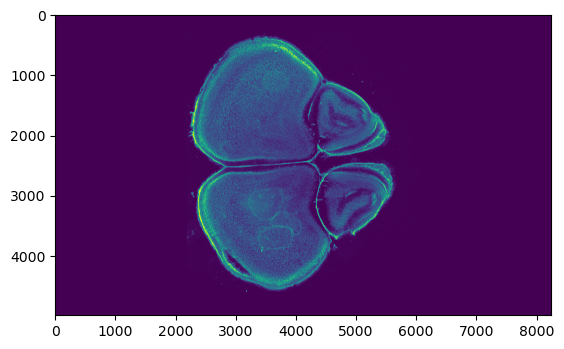

In [29]:
#adaptive padding
#IDEAL DIMENSIONS: (160, 228) ratio
goal_aspect_ratio = 160/228
curr_aspect_ratio = W__.shape[0]/W__.shape[1]

xPad = 300
yPad = 300
if curr_aspect_ratio > goal_aspect_ratio:
    xPad = (((W__.shape[0]+1400)/goal_aspect_ratio) - W__.shape[1])//2
    xPad = int(xPad)
    
padding = ((yPad,yPad),(xPad,xPad))
print("Goal aspect ratio: {}".format(goal_aspect_ratio))
print("Recommended padding: {}".format(padding))
print(W__.shape,curr_aspect_ratio)

W = np.pad(W__,padding,'minimum')
im = plt.imshow(W)

(4986, 8244)
7
(713, 1178)


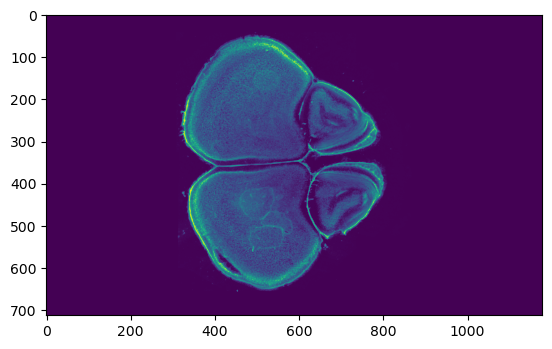

In [30]:
# downscaling
print(W.shape)
ds_factor = np.min(W.shape) / 700 #factor to downscale by
ds_factor = int(ds_factor)
print(ds_factor)
W = ski.transform.downscale_local_mean(W, (ds_factor, ds_factor)) # downsample
print(W.shape)

# plot W to ensure correctness
im = plt.imshow(W)

Prep for STalign

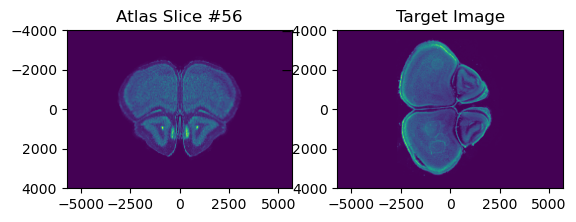

In [31]:
#find slice
#peruse through images in atlas
# Loading the atlas
import time

# stalign seems to use slice+10, not sure why
slice = 56


vol,hdr = nrrd.read(imagefile)
A = vol
vol,hdr = nrrd.read(labelfile)
L = vol

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])

ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title(f'Atlas Slice #{slice}')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

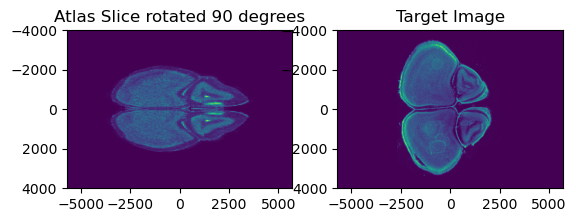

In [32]:
#find rotation


from scipy.ndimage import rotate

theta_deg = 90

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title(f'Atlas Slice rotated {theta_deg} degrees')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

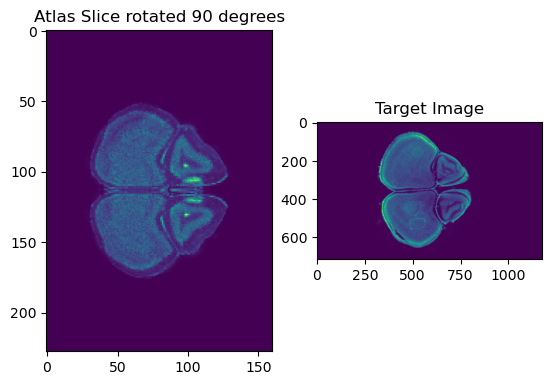

In [33]:
fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg))
ax[0].set_title(f'Atlas Slice rotated {theta_deg} degrees')

ax[1].imshow(W)
ax[1].set_title('Target Image')
fig.canvas.draw()

In [34]:
X_ = np.arange(0,W.shape[1])
Y_ = np.arange(0,W.shape[0])
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2)) # comment this line out when using stalign_no_contrast

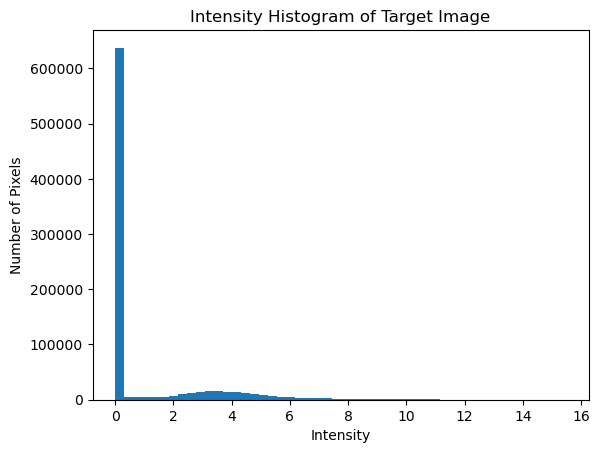

In [35]:
# Intensity Histogram
fig,ax = plt.subplots()
ax.hist(J.ravel(), bins=50)
plt.xlabel('Intensity');
plt.ylabel('Number of Pixels');
plt.title('Intensity Histogram of Target Image');

In [36]:
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

sigmaA = 1 #standard deviation of artifact intensities
sigmaB = .5 #standard deviation of background intensities
sigmaM = 1.5 #standard deviation of matching tissue intenities

muA = torch.tensor([5,5,5],device=device) #average of artifact intensities

muB = torch.tensor([0,0,0],device=device) #average of background intensities
print(muA,muB);

tensor([5, 5, 5], device='cuda:0') tensor([0, 0, 0], device='cuda:0')


In [37]:
slice_offset = 7
slice += slice_offset # correcting for offset'''

In [38]:
# initialize variables
scale_x = 0.1 #default = 0.9
scale_y = 0.1 #default = 0.9
scale_z = 0.9 #default = 0.9
theta0 = torch.tensor((np.pi/180)*theta_deg)

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])

else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])


L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.matmul(L,scale_atlas)#np.identity(3)

Actually Running STalign

<IPython.core.display.Javascript object>


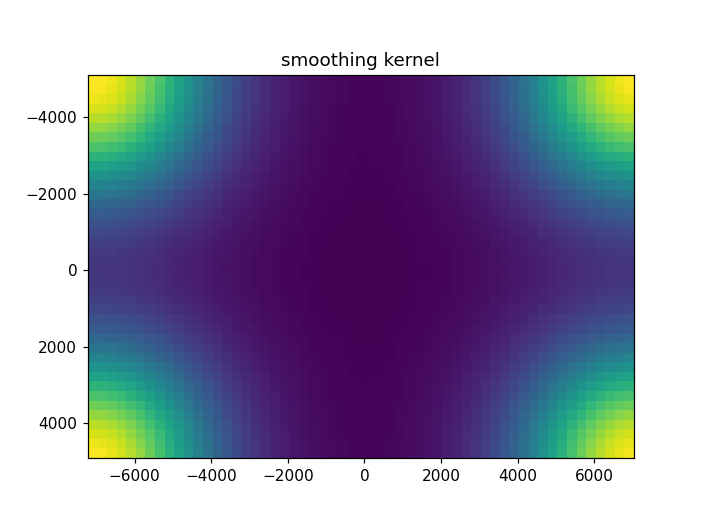

<IPython.core.display.Javascript object>


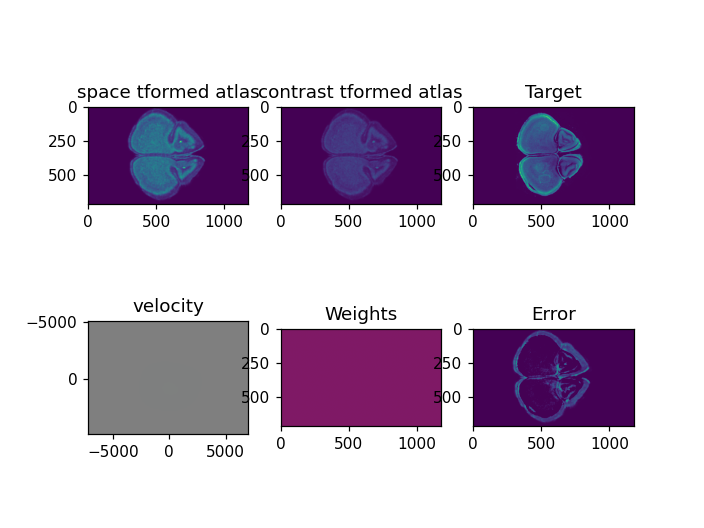

<IPython.core.display.Javascript object>


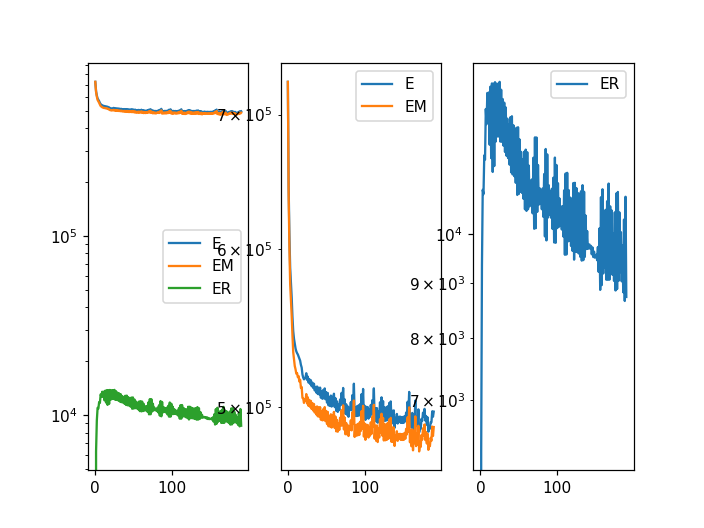

0


C:\Users\Manjari\Documents\Rishi\../Manjari/STalign/STalign\STalign_nocontrast.py:1625: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
CPU times: total: 1min 51s
Wall time: 22.3 s


In [39]:

%%time
%matplotlib notebook
# run LDDMM

#tried:
# epL,epT=

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=200,
    device=device,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB, #average of background intensities
    #a = 500,
    epL = 1e-9,
    epT = 1e-9
)
%matplotlib inline

In [40]:
# Saving all relavant variables
import pickle

# Saving transform
filename = 'transform_hyopil_1_no_contrast.pickle'
with open(filename,'wb') as file:
    pickle.dump(transform, file)
    print('transform check')
    pickle.dump(W,file)
    print('W check')
    pickle.dump(xJ,file)
print("stored")



transform check
W check
stored
